In [333]:
###############################################################################################################################################################################################
###### THIS CELL CONFIGURES THE NOTEBOOK, IMPORTS LIBRARIES AND DECLARE GLOBALS THAT ARE USED THROUGHOUT THIS NOTEBOOK. UPDATE ACCORDING DO YOUR CONFIGURATION + WHAT YOU WANT TO PLOT ########
###############################################################################################################################################################################################
import seaborn as sns                                                                                    
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from os import listdir
import copy
import pickle
import numpy as np
from scipy import stats
import glob

%matplotlib notebook

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

rate = ''
exp_base_folder = os.path.join('/home/maxdml/experiments/', rate, '')
app_name = 'dmtr_http_srv'
client_name = 'rate_client'
stack_name = 'lwip'


tail_to_prune = .99

pd.set_option('float_format', '{:f}'.format)

# core_to_comp = {4: 'network', 5: 'http', 6: 'http'} # This maps a CPU ID to a component in the application (used for PCMs data)
# core_to_comp = {4: 'network'}
core_to_comp = {4: 'network', 5: 'http', 6: 'http', 7: 'http'} 
#  EXEC  : instructions per nominal CPU cycle
#  IPC   : instructions per CPU cycle
#  FREQ  : relation to nominal CPU frequency='unhalted clock ticks'/'invariant timer ticks' (includes Intel Turbo Boost)
#  AFREQ : relation to nominal CPU frequency while in active state (not in power-saving C state)='unhalted clock ticks'/'invariant timer ticks while in C0-state'  (includes Intel Turbo Boost)
#  L3MISS: L3 (read) cache misses
#  L3HIT : L3 (read) cache hits
#  L3HR : L3 (read) cache hit ratio (0.00-1.00)
#  L3MPI : number of L3 (read) cache misses per instruction
#  L2MPI : number of L2 (read) cache misses per instruction
#  READ  : bytes read from main memory controller (in GBytes)
#  WRITE : bytes written to main memory controller (in GBytes)
#  L3OCC : L3 occupancy (in KBytes)
# pcm_stats = ['IPC', 'L3MISS', 'L3HIT', 'L3HR', 'L3MPI', 'L2MPI', 'L3OCC']
pcm_stats = ['L3MISS', 'L3HIT', 'L3OCC', 'L2MISS']
latencies = ['end-to-end']#, 'send', 'receive'] # Rate client application latencies
pollqlen = ['pql']
dmtr_client = ['read', 'write'] # Rate client Demeter push/pop operations
dmtr_server = ['read', 'write'] # Server application Demeter push/pop operations
throughput = ['bps']
components = [v + '-' + str(k) for k,v in core_to_comp.items()]
dtypes = {
    'latencies': latencies,
    'pcms': pcm_stats,
    'throughput': throughput,
    'components': components,
#     'dmtr_client': dmtr_client,
    'dmtr_server': dmtr_server,
    'pql_client': pollqlen,
    'pql_server': pollqlen
}
cache = {}

# cache['exp_name']['latencies']['latency_name']['pickle']
# cache['exp_name']['latencies']['latency_name']['data']
# cache['exp_name']['throughput']
# cache['exp_name']['pcms']

############ New tracing format
trace_label_to_dtype = {
    'client-end-to-end' : ['SENDING', 'COMPLETED'],
    'client-receive'    : ['READING', 'COMPLETED'],
    'client-send'       : ['SENDING', 'READING'],
    'dmtr-client-send'  : ['CLT_PUSH_START', 'CLT_PUSH_END'],
    'dmtr-client-read'  : ['CLT_POP_START', 'CLT_POP_END'],
    'server-net-dispatch-int' : ['NET_RECEIVE', 'HTTP_DISPATCH'],
    'server-net-dispatch-ext' : ['HTTP_DONE', 'NET_SEND'],
    'server-http'       : ['START_HTTP', 'END_HTTP'],
    'server-http-memq-in': ['HTTP_DISPATCH', 'START_HTTP'],
    'server-http-memq-out': ['END_HTTP', 'HTTP_DONE'],
    'dmtr-server-send'  : ['SRV_PUSH_START', 'SRV_PUSH_END'],
    'dmtr-server-read'  : ['SRV_POP_START', 'SRV_POP_END']
}


# plot_type1 = ['latencies', 'components', 'dmtr_client', 'dmtr_server', 'pql_server', 'pql_client'] + trace_label_to_dtype.keys()

In [429]:
##################### Traces description
# 1. CLT_PUSH_START - SENDING           Time between the scheduling of the request and its actual processing
# 2. CLT_PUSH_END - CLT_PUSH_START      Time to prepare the packet, send it to the NIC driver through rte_eth_tx_burst(), and free the dpdk mbuf
# 3. SRV_POP_START - CLT_PUSH_END       Time on the wire: item detected in the io queue's receive queue - client packet sent /!\ I think this can be negative if the server schedule's pop way before the client sends requests
# 4. SRV_POP_END - SRV_POP_START        Time to parse incoming packet + "waiting time" at the server's queue
# 5. NET_RECEIVE - SRV_POP_END          Time between message delivered to the application by dmtr_wait_any() and packet processed by the I/O queue
# 6. HTTP_DISPATCH - NET_RECEIVE        Time taken to select the HTTP recipient (either RR, or apply the filter, etc)
# 7. START_HTTP - HTTP_DISPATCH         Time spent in memory queue between network component and HTTP
# 8. END_HTTP - START_HTTP              Time spent performing HTTP processing
# 9. HTTP_DONE - END_HTTP               Time spent in memory queue between HTTP component and HTPP /!\ This include the "wait time" of dmtr_wait_any, as the same poll operates on both network sockets, and this memory queue
# 10. NET_SEND - HTTP_DONE              Time spent forwarding the answer to the client, from the network component
# 10. SRV_PUSH_START - NET_SEND         Time between the scheduling of the response and its actual processing
# 12. SRV_PUSH_END - SRV_PUSH_START     Time spent preparing the packet and sending it to the wire (identical to #2)
# 13. CLT_POP_START - SRV_PUSH_END      Time spent on the wire /!\ I think this can be negative as the client schedules the read as soon as it as sent the request
# 14. CLT_POP_END - CLT_POP_START       Time spent processing an incoming network packet (includes wait time) (identical to #4)
# 15. COMPLETED - CLT_POP_END           Time ellapsed between the reponse being delivered to the client by dmtr_wait_any(), and the response's being fully processed by the I/O queue
TRACE_ORDER = [
    'SENDING',
    'CLT_PUSH_START',
#     'CLT_PUSH_END',
#     'SRV_POP_START',
    'SRV_POP_END',
    'NET_RECEIVE',
    'HTTP_DISPATCH',
    'START_HTTP',
    'END_HTTP',
    'HTTP_DONE',
    'NET_SEND',
    'SRV_PUSH_START',
#     'SRV_PUSH_END',
#     'CLT_POP_START',
    'CLT_POP_END',
    'COMPLETED'
]

SRV_TRACE_ORDER = [
    'SRV_POP_START',
    'SRV_POP_END',
    'NET_RECEIVE',
    'HTTP_DISPATCH',
    'START_HTTP',
    'END_HTTP',
    'HTTP_DONE',
    'NET_SEND',
    'SRV_PUSH_START',
    'SRV_PUSH_END',
]

CLT_TRACE_ORDER = [
    'SENDING',
    'CLT_PUSH_START',
    'CLT_PUSH_END',
    'CLT_POP_START',
    'CLT_POP_END',
    'READING',
    'COMPLETED'
]

SRV_TRACE_ORDER_STACK = [
    'SRV_POP_END',
    'NET_RECEIVE',
    'HTTP_DISPATCH',
    'START_HTTP',
    'END_HTTP',
    'HTTP_DONE',
    'NET_SEND',
    'SRV_PUSH_START'
]

CLT_TRACE_ORDER_STACK = [
    'SENDING',
    'CLT_PUSH_START',
    'CLT_POP_END',
    'READING',
    'COMPLETED'
]

orders_stack = {client_name: CLT_TRACE_ORDER_STACK, app_name: SRV_TRACE_ORDER_STACK}
orders_all = {client_name: CLT_TRACE_ORDER, app_name: SRV_TRACE_ORDER}
client_orders_all = {client_name: CLT_TRACE_ORDER}

def 5-4http-oneregex-rr.2(trace_dir, exclude_first = 5):
    #REQ_ID	SENDING	READING	COMPLETED	PUSH_TOKEN	POP_TOKEN)
    files = glob.glob(os.path.join(trace_dir, '*traces*'))
    files = list(filter(lambda x: not ('POP' in x or 'PUSH' in x), files))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    
    min_time = df[df.columns[1]].min()
    df = df[df[df.columns[1]] > min_time + exclude_first * 1e9]
    return df

def read_traces(trace_dir, label):
    files = glob.glob(os.path.join(trace_dir, '*%s-traces' % label))
    if len(files) > 1:
        raise Exception("Too many files")
    df = pd.read_csv(files[0], sep='\t')
    return df

def merge_trace(token_df, trace_df, token_label, col_label):
    trace_df = trace_df[['%s_TOKEN' % token_label, 'TIME']]
    df = pd.merge(token_df, trace_df, on='%s_TOKEN' % token_label)
#     return df
    return df.rename(columns={'TIME': col_label})

def merge_traces(token_df, trace_df, token_label, col_label):
    start_df = trace_df[trace_df.START]
    stop_df = trace_df[~trace_df.START]

    df = merge_trace(token_df, start_df, token_label, '%s_%s_START' % (col_label, token_label))
    df = merge_trace(df, stop_df, token_label, '%s_%s_END' % (col_label, token_label))
    return df

def order_cols(df, order, subtract_root=True):
    col_order = list(filter(lambda x: x in df.columns, order, ))
    df = df[['REQ_ID'] + col_order].set_index('REQ_ID')
    
    if subtract_root:
        df[col_order] = df[col_order].apply(lambda x: x - df[col_order[0]])
    return df

col_labels = {client_name: 'CLT', app_name: 'SRV'}
token_labels = {client_name: 'rate_client', app_name: ''}
def read_profiling_node(base_dir, experiment, node_label, subtract_root=True, orders=orders_stack):
    client_dir = os.path.join(base_dir, experiment, node_label)
    token_df = read_tokens(client_dir)
    push_df = read_traces(client_dir, 'PUSH')
    pop_df = read_traces(client_dir, 'POP')
    
    df = merge_traces(token_df, push_df, 'PUSH', col_labels[node_label])
    df = merge_traces(df, pop_df, 'POP', col_labels[node_label])
    
    return order_cols(df, orders[node_label], subtract_root=subtract_root)

CLIENT_RCV = 'CLT_POP_END'
CLIENT_SND = 'CLT_PUSH_START'    
def read_merged_profiling(base_dir, experiment):
    client_df = read_profiling_node(base_dir, experiment, client_name)
    server_df = read_profiling_node(base_dir, experiment, app_name)
    
    server_cols = server_df.columns
    client_cols = client_df.columns
    
    df = client_df.join(server_df).dropna()

    offset = df[CLIENT_SND]
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    offset = (df[CLIENT_RCV] - df[server_cols[-1]]) / 2    
    df[server_cols] = df[server_cols].apply(lambda x: x + offset)
    return order_cols(df.reset_index(), TRACE_ORDER)

def read_exp_traces(exp):
    client_df = read_profiling_node(exp_base_folder, exp, client_name, orders)
    server_df = read_profiling_node(exp_base_folder, exp, app_name)
    return client_df.join(server_df).dropna()

def prepare_client_traces(exps, data_types, reset_time=True, seconds=True, pctl=1):
    setups = {}
    for exp in exps:
        main_df = read_profiling_node(exp_base_folder, exp, client_name, subtract_root=False, orders=client_orders_all)
        setups[exp] = {}
        for data_type in data_types:
            setups[exp][data_type] = pd.DataFrame({
                'TIME': main_df[trace_label_to_dtype[data_type][0]],
                'VALUE': main_df[trace_label_to_dtype[data_type][1]] - main_df[trace_label_to_dtype[data_type][0]]
            })
            if reset_time:
                setups[exp][data_type].TIME -= min(setups[exp][data_type].TIME)
            if seconds:
                setups[exp][data_type].TIME /= 1e9
            if pctl != 1:
                setups[exp][data_type] = setups[exp][data_type][setups[exp][data_type].VALUE >= setups[exp][data_type].VALUE.quantile(pctl)]
                
    return setups

def prepare_traces(exps, data_types, reset_time=True, seconds=True, pctl=1):
    setups = {}
    for exp in exps:
        client_df = read_profiling_node(exp_base_folder, exp, client_name, subtract_root=False, orders=orders_all)
        server_df = read_profiling_node(exp_base_folder, exp, app_name, subtract_root=False, orders=orders_all)
        main_df = client_df.join(server_df).dropna()
        setups[exp] = {}
        for data_type in data_types:
            setups[exp][data_type] = pd.DataFrame({
                'TIME': main_df[trace_label_to_dtype[data_type][0]],
                'VALUE': main_df[trace_label_to_dtype[data_type][1]] - main_df[trace_label_to_dtype[data_type][0]]
            })
            if reset_time:
                setups[exp][data_type].TIME -= min(setups[exp][data_type].TIME)
            if seconds:
                setups[exp][data_type].TIME /= 1e9
            if pctl != 1:
                setups[exp][data_type] = setups[exp][data_type][setups[exp][data_type].VALUE >= setups[exp][data_type].VALUE.quantile(pctl)]
                
    return setups

def read_csv(csvfile, data_type, setup, reset_time=True, second_ts=True, prune=False, set_rate=False):
    #if data_type == 'latencies':
    #    df = pd.read_csv(csvfile, delimiter='\t', skipfooter=1).sort_values('TIME')
    #else:
    df = pd.read_csv(csvfile, delimiter='\t').sort_values('TIME')
    if reset_time:
        df.TIME -= min(df.TIME)
    if second_ts:
        df.TIME /= 1e9
    if prune:
        value_df = df.loc[:, df.columns == 'VALUE']
        high = int(value_df.quantile(q=.9999))
        value_df = value_df.apply(lambda x: x[x < high])
        df = pd.concat([df.loc[:, 'TIME'], value_df], axis=1)
        df.dropna(inplace=True)
    
    df = df[df.TIME > 5]

    if set_rate:
        df['rate'] = (int(setup.split('-')[0]) * 1000) # ATTENTION: this is totally ad-hoc to file naming, and *has* changed over time
    df['label'] = setup    
    return df

def prune_df(df):
    return df[df.VALUE < df.VALUE.quantile(tail_to_prune)]

def tail_df(df):
    return df[df.VALUE > df.VALUE.quantile(.90)]

# Application latencies
def read_client_latencies(lat, dtype, exp):
    exp_folder = os.path.join(exp_base_folder, exp, '')
    filename = os.path.join(exp_folder, client_name, exp + '_' + lat)
    df = read_csv(filename, dtype, exp, set_rate=True)
    return df

def read_qpl(lat, dtype, exp):
    exp_folder = os.path.join(exp_base_folder, exp, '')
    if dtype.split('_')[1] == 'client':
        folderpath = os.path.join(exp_folder, client_name, '')
    else:
        folderpath = os.path.join(exp_folder, app_name, '')
    filename = os.path.join(folderpath, exp + '_' + lat)
    df = read_csv(filename, dtype, exp)
    return df

# Demeter queues latencies
def read_dmtr_latencies(lat, dtype, exp):
    # List all files (pthread_id-{read,write}-latencies)
    exp_folder = os.path.join(exp_base_folder, exp, '')
    filename_pattern = lat + "-latencies"
    if dtype.split('_')[1] == 'client':
        folderpath = os.path.join(exp_folder, client_name, '')
    else:
        folderpath = os.path.join(exp_folder, app_name, '')
    files = [os.path.join(folderpath, f) for f in listdir(folderpath) if os.path.isfile(os.path.join(folderpath, f)) and f.endswith(filename_pattern)]
    df = pd.DataFrame()
    for f in files:
        pthread_id = os.path.split(f)[1].split('-')[0] # os.path.split() returns a tuple (head, tail)
        new_df = read_csv(f, dtype, exp)
        new_df['worker_pid'] = pthread_id
        df = df.append(new_df)
    return df

# Ethq data
# FIXME: untested since we work on DeDoS cluster
def read_ethq_data(lat, dtype, exp, **kwargs):
    exp_folder = os.path.join(exp_base_folder, exp, '')
    filename = os.path.join(exp_folder, 'ethq', 'ethq.log')
    df = pd.read_csv(filename, delimiter='\t')
    df.time -= min(df.time)
    df.time /= 1e9
    df.set_index('time', inplace=True)
    df = df[df.NIC.isin(['eno5-1', 'eno5-2', 'eno5-5', 'eno5-6']) & ((df.T.drop('NIC') != 0).any())]
    df['rate'] = int(setup.strip(stack_name).split('_')[0]) / 10 * 100
    df['label'] = exp
    return df

#Hardware Performance Counter monitors
def read_pcm_data(lat, dtype, exp, **kwargs):
    exp_folder = os.path.join(exp_base_folder, exp, '')
    filename = os.path.join(exp_folder, 'pcm', 'pcm.csv')
    raw_pcm_df = pd.read_csv(filename, delimiter=',', skiprows=1)
    raw_pcm_df.Time = pd.to_datetime(raw_pcm_df.Time).values.astype(np.int64) // 10**9
    raw_pcm_df.Time -= min(raw_pcm_df.Time)
    #This is a fix for the "incorrect" automatic column labelling from pd.read_csv()
    updated_cols = {'L3OCC.' + str(i) : 'L3OCC.' + str(i+1) for i in range(1,10)}
    updated_cols['L3OCC'] = 'L3OCC.1'
    raw_pcm_df = raw_pcm_df.rename(columns=updated_cols)
    cols = ['Date', 'Time']
    for core in core_to_comp.keys():
        new_cols = [stat+'.{}'.format(str(core)) for stat in pcm_stats]
        cols.extend(new_cols)
    return raw_pcm_df[cols]

# Application components latencies
def read_components_latencies(lat, dtype, exp):
    exp_folder = os.path.join(exp_base_folder, exp, '')
    c_name, c_id = lat.split('-')
    filename = exp + '_' + c_name + '-runtime-' + c_id #e.g. lwip06_http-runtime-1
    filepath = os.path.join(exp_folder, app_name, filename)
    df = read_csv(filepath, dtype, exp, set_rate=True)
    return df
                        
# reset the cache here means replacing the dataframes even if they are cached
#FIXME: we should only keep the "per_dtype" dict format, and filter what we need later
def prepare_data(exps, data_types, prune=False, tail=False, reset_cache=False, per_dtype=False):
    setups = {}
    for exp in exps:
        if not per_dtype:
            setups[exp] = {}
        for dtype in data_types:
            if per_dtype and dtype not in setups:
                setups[dtype] = {}
            elif not per_dtype:
                setups[exp][dtype] = {}
            for lat in dtypes[dtype]:
                if dtype == 'pcms':
                    lat = dtype
    
                if not reset_cache and dtype in cache[exp] and lat in cache[exp][dtype] and 'data' in cache[exp][dtype][lat]:
                    df = cache[exp][dtype][lat]['data']
                else:
                    df = dtype_readers[dtype](lat, dtype, exp)
                    if dtype in ['latencies', 'components']:    
                        if prune:
                            df = prune_df(df)
                        if tail:
                            df = tail_df(df)
                    setup_cache([exp], [dtype])
                    cache[exp][dtype][lat]['data'] = df
                
                if per_dtype:
                    if lat not in setups[dtype]:
                        setups[dtype][lat] = df
                    else:
                        setups[dtype][lat] = setups[dtype][lat].append(df)
                else:
                    setups[exp][dtype][lat] = df #'lat' should be in setups[exp][dtype]

                if dtype == 'pcms':
                    break # PCMS data are not read by lat, but rather we make one df with all the counters
    
    return setups

def setup_cache(exps, data_types, reset_exps=False, reset_type=False, reset_lat=False):
    for exp in exps:
        if exp not in cache or reset_exps:
            cache[exp] = {}
        for t in data_types:
            if t not in cache[exp] or reset_type:
                cache[exp][t] = {}
            if t in ['latencies', 'components', 'dmtr_client', 'dmtr_server', 'pql_client', 'pql_server']:
                for dtype in dtypes[t]:
                    if dtype not in cache[exp][t] or reset_lat:
                        cache[exp][t][dtype] = {}
            if t == 'pcms':
                cache[exp][t][t] = {}

def plot_all_setups(exps, data_types=[], reset_cache=False):
    plt.close('all')
    if (len(data_types) == 0):
        data_types = ['latencies']

    if reset_cache or bool(cache) == False:
        setup_cache(exps, data_types, reset_exps=True, reset_lat=True)

    setups = prepare_data(exps, data_types, per_dtype=True)

    for i, dtype in enumerate(data_types):
        if dtype not in ['latencies', 'components', 'dmtr_client', 'dmtr_server']:
            print('Unsupported latency {} for grouped plot'.format(dtype))
            continue
        # Instantiate the figure
        plt.figure(i+1, figsize=(8, 15))
        fig, axs = plt.subplots(len(dtypes[dtype]), 1, squeeze=False, sharey='row', sharex=True, num=i+1)
        for r_index, lat in enumerate(dtypes[dtype]):
            sns.barplot(x='rate', y='VALUE', hue='label', data=setups[dtype][lat], ax=axs[r_index][0])
        
    
#reset the cache here means refreshing the entries for the given exps and data_types
def plot_setups(exps, data_types=[], reset_cache=False, stacking=True, show_ts=False):
    plt.close('all')
    if (len(data_types) == 0):
        data_types = ['latencies']

    if reset_cache or bool(cache) == False:
        setup_cache(exps, data_types, reset_exps=True, reset_lat=True)

    setups = prepare_data(exps, data_types, reset_cache=reset_cache)

    reset_cache = True #FIXME: Pickling does not work as intended as of now

    # First compute layout for the figure
    if stacking:
        ncols = 1
    else:
        ncols = len(setups)
        
    pcm_ylimits = {stat: -999 for stat in pcm_stats}

    for i, t in enumerate(data_types):
        # Instantiate the figure
        plt.figure(i+1, figsize=(10, 10))
        fig, axs = plt.subplots(len(dtypes[t]), ncols, squeeze=False, sharey='row', sharex=True, num=i+1)   
        for j, setup in enumerate(setups.keys()):
            c_index = j % ncols

            # FIXME: this plots all dmtr_* queue latencies in the same plot, regardless of the thread_id
            if t in ['latencies', 'components', 'dmtr_client', 'dmtr_server', 'pql_server', 'pql_client']:
                if not reset_cache and 'pickle' in cache[setup][t][lat] and os.path.getsize(cache[setup][t][lat]['pickle']) > 0:
#                     fig.delaxes(axs[0][index])
#                     pickle.load(open(cache[setup][t]['pickle'], 'rb'))
                    pass
                else:
                    for r_index, lat in enumerate(dtypes[t]):
                        if show_ts:
                            sns.scatterplot(x=setups[setup][t][lat].TIME, y='VALUE', data=setups[setup][t][lat], ax=axs[r_index][c_index], label=setup)
                            axs[r_index][c_index].set(xlabel='Time', ylabel='latency (ns)')
                        else:
#                             sns.lineplot(x=np.sort(setups[setup][t][lat].VALUE), y=np.linspace(0, 1, len(setups[setup][t][lat].VALUE)), label=setup, ax=axs[r_index][c_index])
#                             sns.distplot(setups[setup][t][lat].VALUE, ax=axs[r_index][c_index], label=setup, hist_kws=dict(cumulative=True), bins=None)
                            axs[r_index][c_index].plot(np.sort(setups[setup][t][lat].VALUE), np.linspace(0, 1, len(setups[setup][t][lat].VALUE), endpoint=False), label=setup)
                            axs[r_index][c_index].set(xlabel='latency (ns)', ylabel='#requests')
                        if stacking:
                            axs[r_index][c_index].set_title('{}'.format(lat))
                        else:
                            axs[r_index][c_index].set_title('{} {}'.format(lat, setup))

                        axs[r_index][c_index].ticklabel_format(style='plain')
                        axs[r_index][c_index].legend()

#                         pickle.dump(axs[r_index], open(setup + '-' + t + '.pickle', 'wb'))
#                         cache[setup][t]['pickle'] = setup + '-' + t + '.pickle'
        
            if t == 'pcms':
                for i, dtype in enumerate(dtypes[t]):
                    stat_names = [dtype + '.{}'.format(str(core_id)) for core_id in core_to_comp.keys()]
                    legends = []
                    for c, stat in enumerate(stat_names):
                        stat_name, core_id = stat.split('.')
                        s = sns.scatterplot(x = setups[setup][t][t].Time, y=stat, data=setups[setup][t][t], palette='colorblind', ax=axs[i][c_index], legend=False)
                        axs[i][c_index].set(xlabel='Time')
                        axs[i][c_index].set_title('{}'.format(stat), fontsize=6)
                        ylimit = max(pcm_ylimits[stat_name], max(setups[setup][t][t][stat]) + max(setups[setup][t][t][stat]) * 0.1)
                        if ylimit > pcm_ylimits[stat_name]:
                            pcm_ylimits[stat_name] = ylimit
                        axs[i][c_index].set_ylim(0, ylimit)
                        legends.append(core_to_comp[int(core_id)] + '-' + core_id)
                    axs[i][c_index].legend(legends, loc=1)
                    axs[i][c_index].set_ylabel(stat_name)
                    axs[i][c_index].set_title('')

#             if t == 'throughput':               
#                 # Merge all the throughput DF together. Hue will be setup
#                 tps = []
#                 for setup in setups:
#                     setups[setup]['throughput']['exp'] = setup     
#                     tps.append(setups[setup]['throughput'])
#                 df = pd.concat(tps)
#                 fig, axs = plt.subplots(1, 2, squeeze=False, sharey=False)
#                 sns.lineplot(x=df.index, y='TX Mbps', hue='exp', data=df, ax=axs[0][0], ci=None)
#                 sns.lineplot(x=df.index, y='RX Mbps', hue='exp', data=df, ax=axs[0][1], ci=None)

def plot_setups_traces(exps, data_types=[], client_only=False, reset_cache=False, stacking=True, show_ts=False, pctl=1):
    plt.close('all')
    if (len(data_types) == 0):
        data_types = ['client-end-to-end']

    if client_only:
        setups = prepare_client_traces(exps, data_types, pctl=pctl)
    else:
        setups = prepare_traces(exps, data_types, pctl=pctl)
        
    # First compute layout for the figure
    if stacking:
        ncols = 1
    else:
        ncols = len(setups)

    for i, t in enumerate(data_types):
        # Instantiate the figure
        plt.figure(i+1, figsize=(10, 10))
        fig, axs = plt.subplots(1, ncols, squeeze=False, sharey='row', sharex=True, num=i+1)   
        for j, setup in enumerate(setups.keys()):
            c_index = j % ncols
            r_index = 0
            if show_ts:
                sns.scatterplot(x=setups[setup][t].TIME, y='VALUE', data=setups[setup][t], ax=axs[r_index][c_index], label=setup)
                axs[r_index][c_index].set(xlabel='Time', ylabel='latency (ns)')
            else:
#                 sns.lineplot(x=sorted(setups[setup][t].VALUE), y=len(setups[setup][t].VALUE), ax=axs[r_index][c_index])
#                 sns.distplot(setups[setup][t].VALUE, ax=axs[r_index][c_index], label=setup, kde=True, kde_kws=dict(cumulative=True), bins=None)
#                 sns.distplot(setups[setup][t].VALUE, ax=axs[r_index][c_index], label=setup, hist_kws=dict(cumulative=True), bins=None) #hist_kws=dict(cumulative=True), 
#                 sns.lineplot(x=np.sort(setups[setup][t].VALUE), y=np.linspace(0, 1, len(setups[setup][t].VALUE)), label=setup, ax=axs[r_index][c_index])
                if pctl != 1:
                    base = pctl
                else:
                    base = 0
                axs[r_index][c_index].plot(np.sort(setups[setup][t].VALUE), np.linspace(base, 1, len(setups[setup][t].VALUE), endpoint=False), label=setup)
#                 axs[r_index][c_index].set(xlabel='latency (ns)', ylabel='% requests')
            if stacking:
                axs[r_index][c_index].set_title('{}'.format(t))
            else:
                axs[r_index][c_index].set_title('{} {}'.format(t, setup))

            axs[r_index][c_index].ticklabel_format(style='plain')
            axs[r_index][c_index].legend()

dtype_readers = {
    'latencies'   : read_client_latencies,
    'dmtr_client' : read_dmtr_latencies,
    'dmtr_server' : read_dmtr_latencies,
    'components'  : read_components_latencies,
    'throughput'  : read_ethq_data,
    'pcms'        : read_pcm_data,
    'pql_server'  : read_qpl,
    'pql_client'  : read_qpl
}

COLORS = ["#700f00",
"#013fb0",
"#cbcd11",
"#6b3a7d",
"#ff392e",
"#008eb2",
"#ff8da5",
"#000000",
"#458f00",
"#AAAAAA",
"#123456",
"#7192F1",
"#013fb0",
'#777777',
'#BBBBBB'
]

def stacked_plot(df, full_sep=False):
    columns = df.columns
    print(columns)
    bottom = 0
    cols_so_far = []
    for prev_col, next_col, color in zip(columns, columns[1:], COLORS):
        if not full_sep:
            bottom = df[prev_col]
        plt.bar(df.index, df[next_col] - df[prev_col], 1, bottom=bottom, color=color, label=prev_col)
        if full_sep:
            bottom = (bottom + df[next_col]- df[prev_col]).max()
            
def plot_stacked_sample(df, sample_size=100, full_sep=False):
    plt.close('all')
    df = df.sort_values(df.columns[-1])

    lowest = df.iloc[:sample_size]
    highest = df.iloc[-sample_size:]
    middlest = df.iloc[int(len(df) / 2 - sample_size / 2): int(len(df) / 2 + sample_size / 2)]

    plt.figure(figsize=(9.5, 4))
    ax1 = plt.subplot(131)
    stacked_plot(lowest.reset_index(drop=True), full_sep)
    ax2 = plt.subplot(132, sharey=ax1)
    stacked_plot(middlest.reset_index(drop=True), full_sep)
    plt.subplot(133, sharey=ax2)
    stacked_plot(highest.reset_index(drop=True), full_sep)
    plt.tight_layout()
    plt.subplots_adjust(top=.8)
    plt.sca(ax2)

    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=5)

In [813]:
plt.close('all')

In [ ]:
exps = ['852kuris2']
# client_df = read_profiling_node(exp_base_folder, '852kuris2', client_name)
# server_df = read_profiling_node(exp_base_folder, '852kuris2', app_name)
df = read_exp_traces("852kuris2")
plot_stacked_sample(df, 200)

<IPython.core.display.Javascript object>


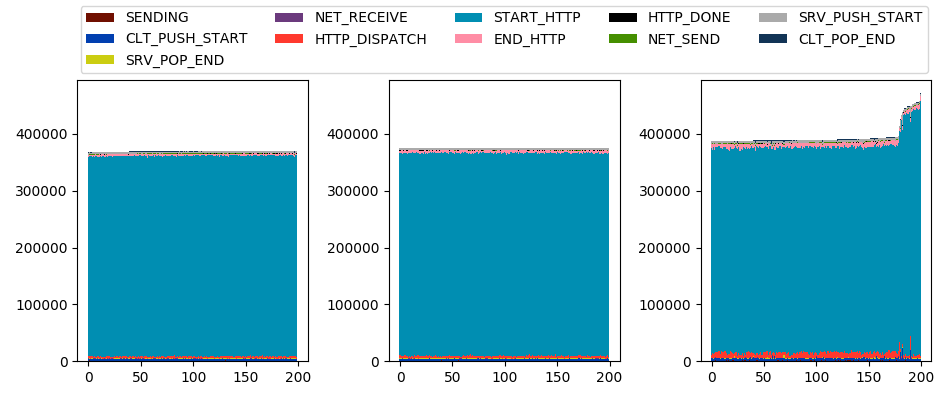

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [63]:
df2 = read_merged_profiling(exp_base_folder, '1-1http-onebiguris.1')
plot_stacked_sample(df2, 200)

<IPython.core.display.Javascript object>


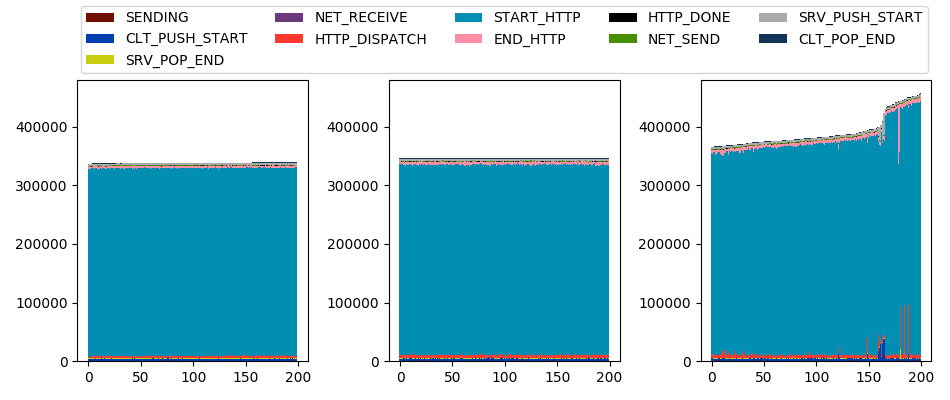

Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')
Index(['SENDING', 'CLT_PUSH_START', 'SRV_POP_END', 'NET_RECEIVE',
       'HTTP_DISPATCH', 'START_HTTP', 'END_HTTP', 'HTTP_DONE', 'NET_SEND',
       'SRV_PUSH_START', 'CLT_POP_END', 'COMPLETED'],
      dtype='object')


In [67]:
df2 = read_merged_profiling(exp_base_folder, '2-2http-onebiguris.1')
plot_stacked_sample(df2, 200)

In [ ]:
core_to_comp = {4: 'network', 5: 'http', 6: 'http', 7: 'http'} 
exps = ['2-3http-oneregex.1']
pcms = prepare_data(exps, ['pcms'], reset_cache=True)
df = pcms[exps[0]]['pcms']['pcms']
df.sum(axis=0)

In [ ]:
core_to_comp = {4: 'network', 5: 'http', 6: 'http'}
exps = ['2-2http-oneregex.1']
pcms = prepare_data(exps, ['pcms'], reset_cache=True)
df = pcms[exps[0]]['pcms']['pcms']
df.sum(axis=0)

In [ ]:
core_to_comp = {4: 'network', 5: 'http'} 
exps = ['5-1http-oneregex-rr.2']
pcms = prepare_data(exps, ['pcms'], reset_cache=True)
df = pcms[exps[0]]['pcms']['pcms']
df.sum(axis=0)

In [ ]:
exp_folder = os.path.join(exp_base_folder, '1-2http-onebiguris-filter-cat.1', '')
filename = os.path.join(exp_folder, 'pcm', 'pcm.csv')
raw_pcm_df = pd.read_csv(filename, delimiter=';', skiprows=1)
raw_pcm_df.Time = pd.to_datetime(raw_pcm_df.Time).values.astype(np.int64) // 10**9
raw_pcm_df.Time -= min(raw_pcm_df.Time)
np.array(raw_pcm_df.columns)
#This is a fix for the "incorrect" automatic column labelling from pd.read_csv()
updated_cols = {'L3OCC.' + str(i) : 'L3OCC.' + str(i+1) for i in range(1,10)}
updated_cols['L3OCC'] = 'L3OCC.1'
raw_pcm_df = raw_pcm_df.rename(columns=updated_cols)
cols = ['Date', 'Time']
for core in core_to_comp.keys():
    new_cols = [stat+'.{}'.format(str(core)) for stat in pcm_stats]
    cols.extend(new_cols)
raw_pcm_df[cols]

<IPython.core.display.Javascript object>


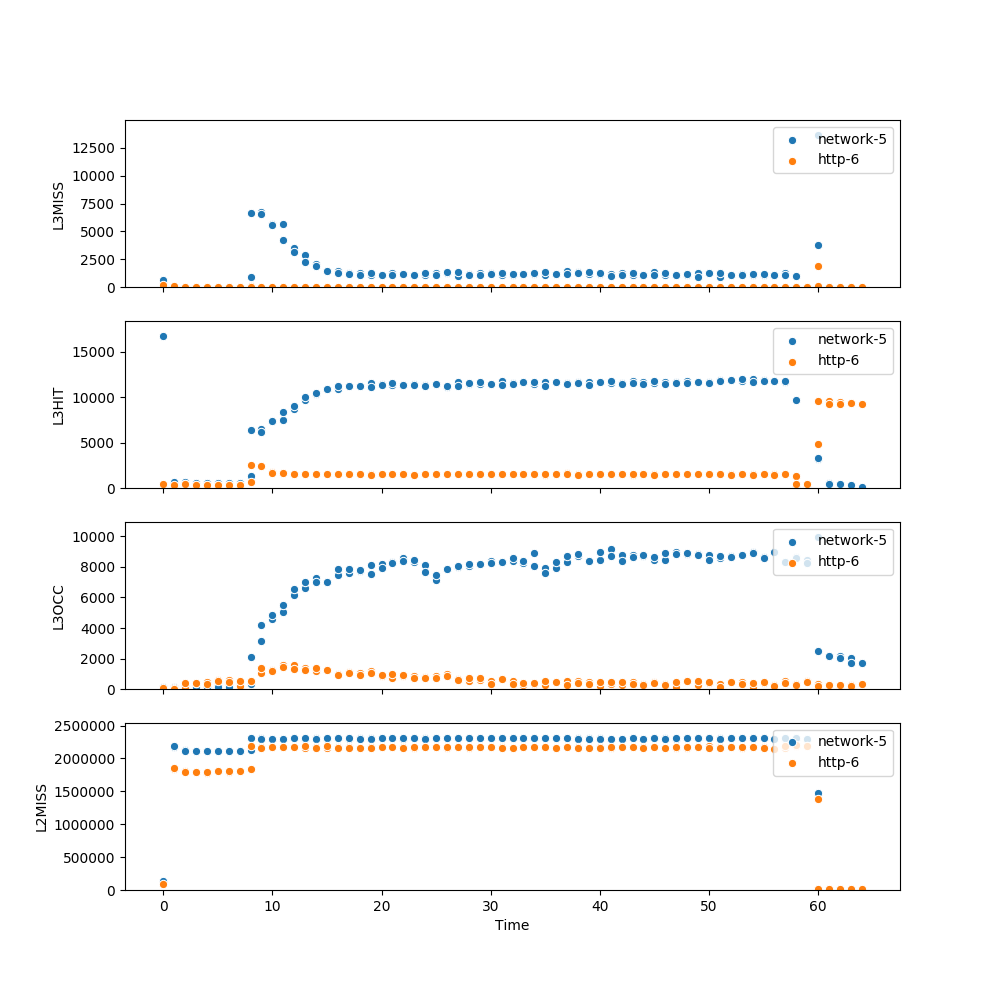

In [496]:
core_to_comp = {
#     1: 'notused',
#     2: 'notused',
#     3: 'notused',
#     4: 'network',
    5: 'network',
    6: 'http',
#     7: 'http',
#     8: 'notused',
#     9: 'notused',
} 
exps = ['5-1http-oneregex-rr.2']
data_types = ['pcms']
# data_types = trace_label_to_dtype.keys()
plot_setups(exps, data_types, show_ts=False, stacking=False, reset_cache=True)

<IPython.core.display.Javascript object>


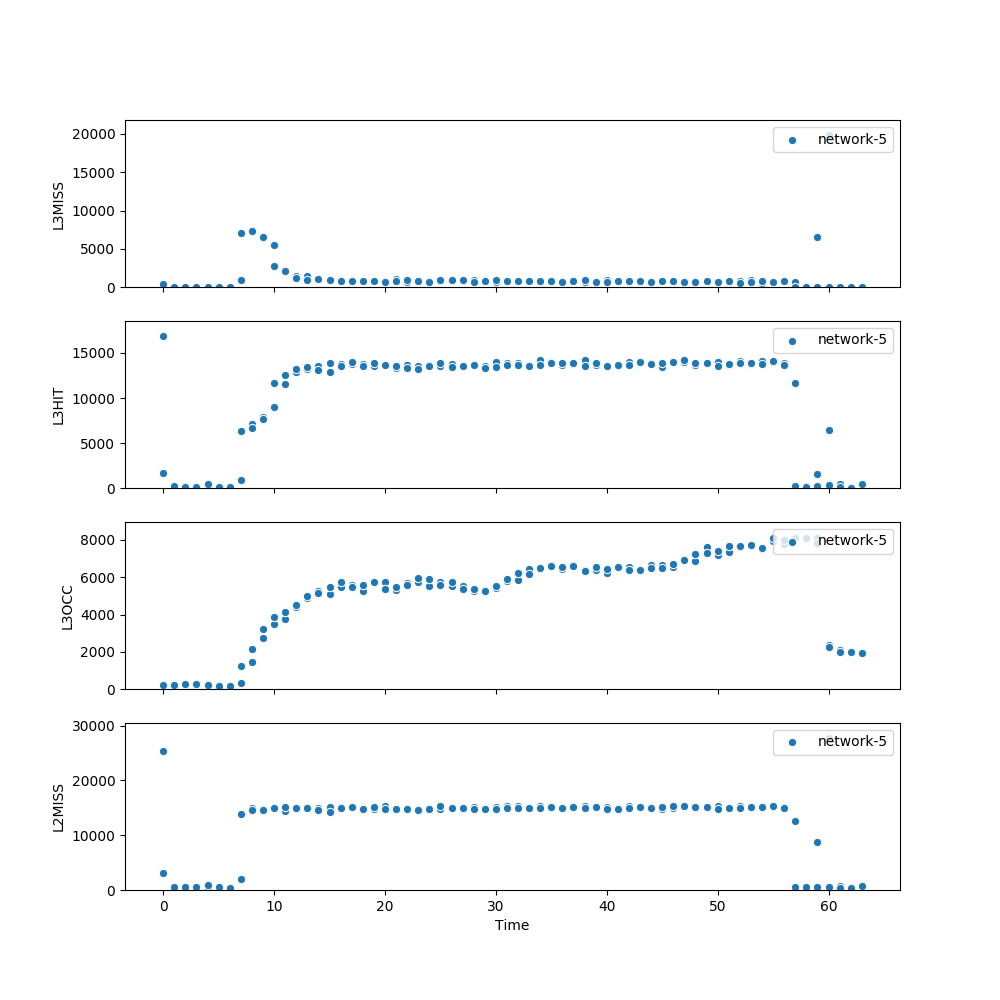

In [469]:
core_to_comp = {
#     1: 'notused',
#     2: 'notused',
#     3: 'notused',
#     4: 'notused',
    5: 'network',
#     6: 'http',
#     7: 'http',
#     8: 'notused',
#     9: 'notused',
} 
exps = ['5-nosplit-oneregex-rr.1']
data_types = ['pcms']
# data_types = trace_label_to_dtype.keys()
plot_setups(exps, data_types, show_ts=False, stacking=False, reset_cache=True)

<IPython.core.display.Javascript object>


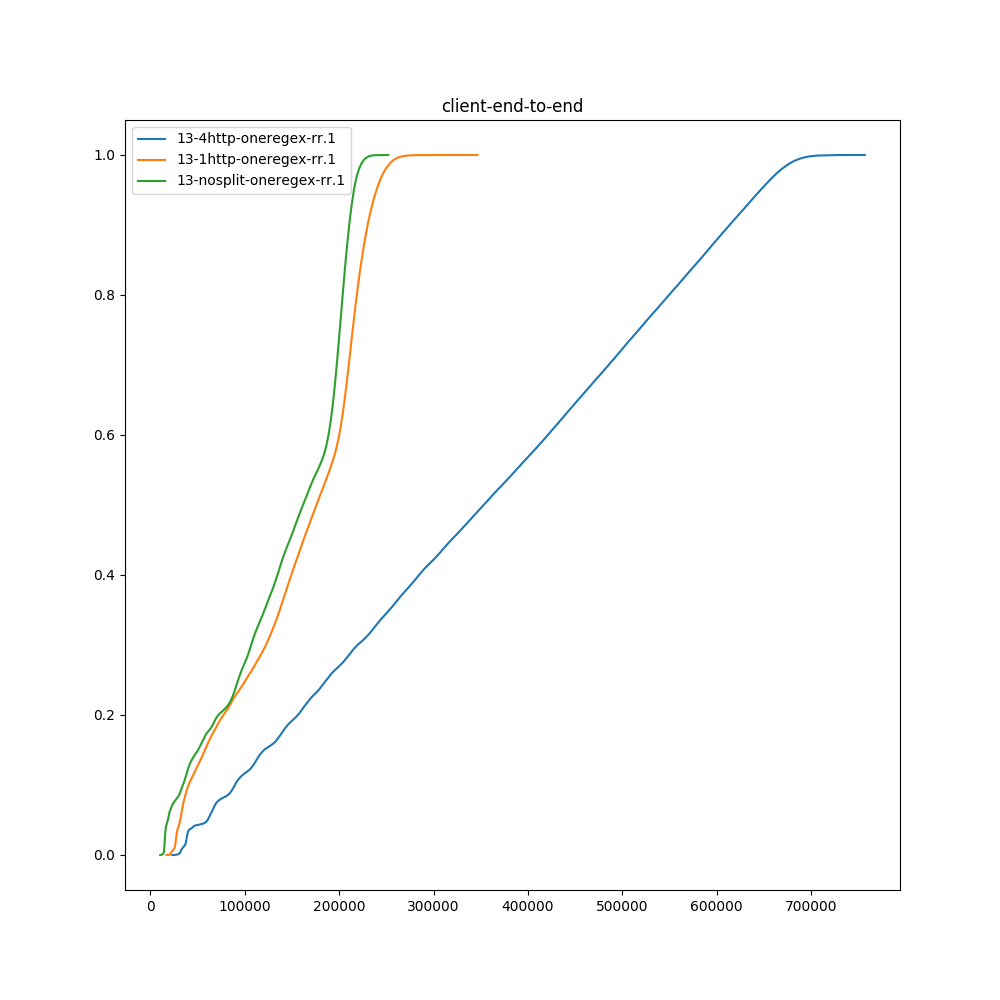

In [473]:
exps = ['13-4http-oneregex-rr.1', '13-1http-oneregex-rr.1', '13-nosplit-oneregex-rr.1']
data_types = ['client-end-to-end']
# data_types = trace_label_to_dtype.keys()
plot_setups_traces(exps, data_types, show_ts=False, stacking=True, pctl=1, client_only=True)

<IPython.core.display.Javascript object>


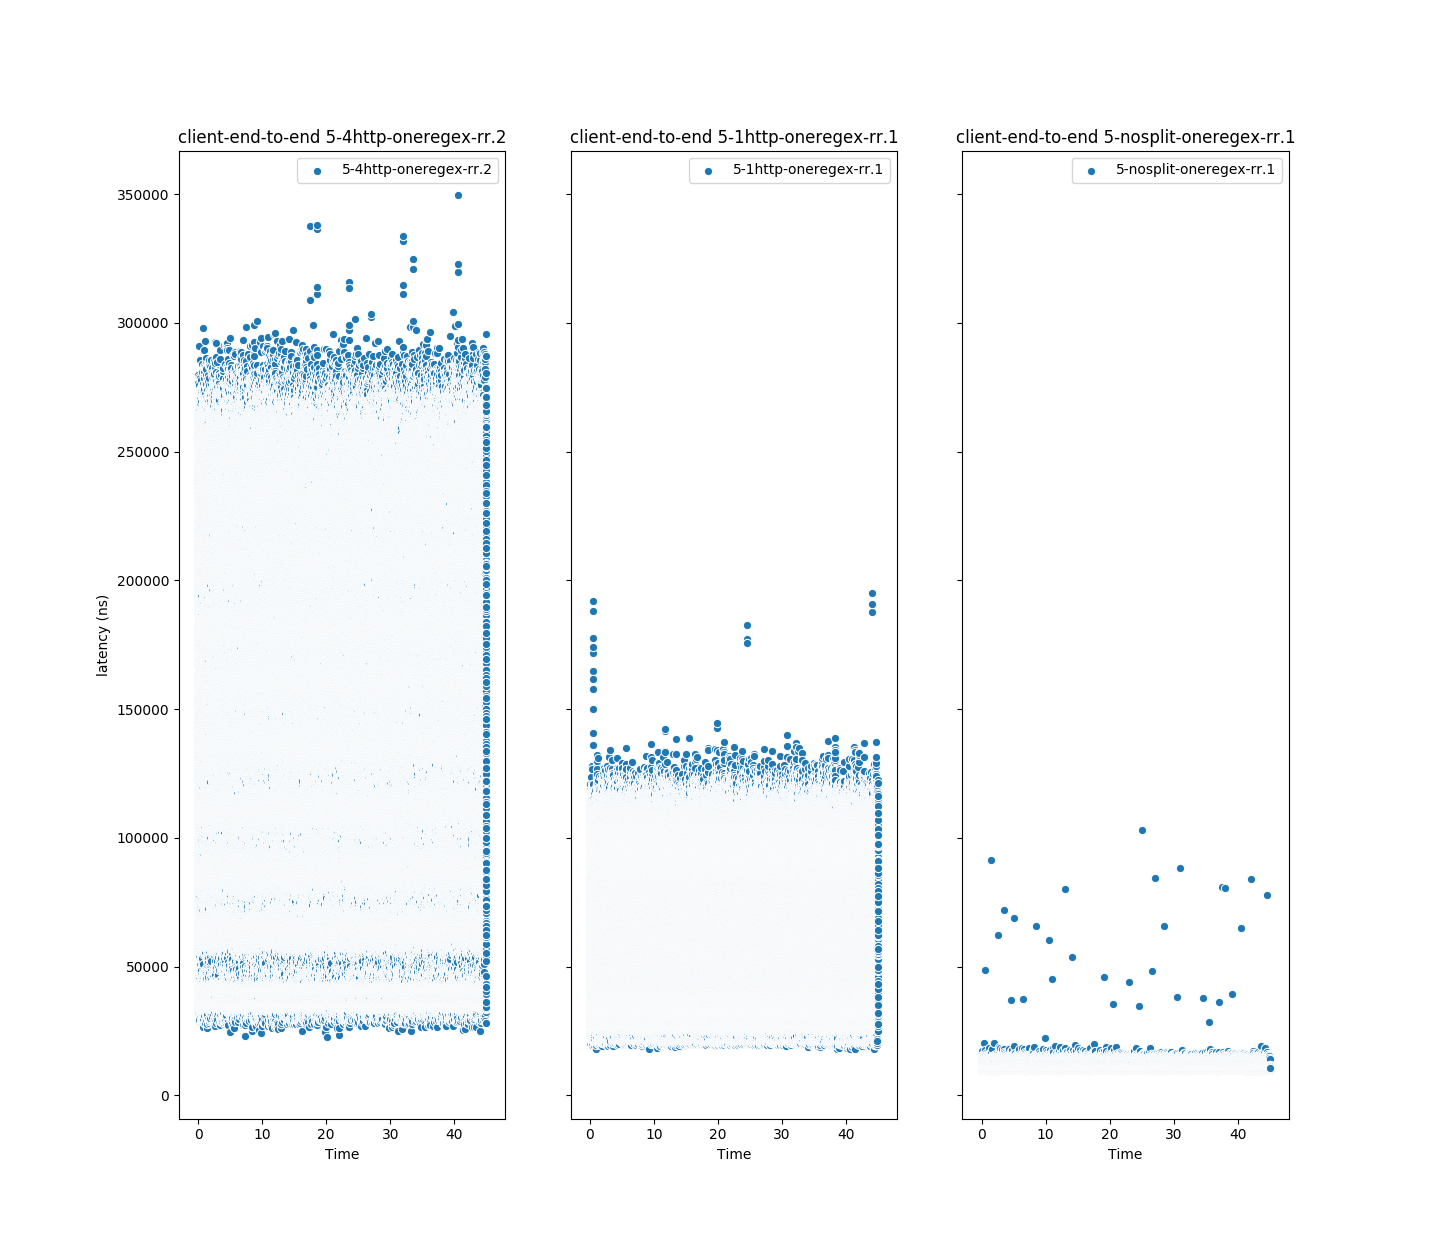

In [498]:
exps = ['5-4http-oneregex-rr.2', '5-1http-oneregex-rr.1', '5-nosplit-oneregex-rr.1']
data_types = ['client-end-to-end']
# data_types = trace_label_to_dtype.keys()
plot_setups_traces(exps, data_types, show_ts=True, stacking=False, pctl=1, client_only=True)

In [12]:
plt.close('all')

###############VRAC



        ###### Cachestat numbers
    #     cols = s[exps[0]]['cachestats'].drop('TIME', axis=1).columns
    #     fig, axs = plt.subplots(len(cols), len(exps), squeeze=False, sharex=True)
    #     for i, setup in enumerate(s.keys()):
    #         for j, col in enumerate(cols):
    #             sns.scatterplot(x = s[setup]['cachestats'].TIME, y=col, data=s[setup]['cachestats'], palette='colorblind', ax=axs[j][i])
    #             if i > 0:
    #                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='')
    #             else:
    #                 axs[j][i].set(xlabel='Timestamp (s)', ylabel='{}'.format(col))
    #         axs[0][i].set_title('Cache statistics: {}'.format(setup))

        ###### other types of plots for latencies

    #             fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True)
    #             for i, setup in enumerate(setups.keys()):
    #                 sns.scatterplot(x = setups[setup]['e2e'].TIME, y='VALUE', data=setups[setup]['e2e'], palette='colorblind', ax=axs[0][i])
    #                 axs[0][i].set(xlabel='Timestamp', ylabel='latency (ns)')
    #                 axs[0][i].set_title('End to end latency: {}'.format(setup))
    #             fig, axs = plt.subplots(1, len(exps), squeeze=False, sharey=True, sharex=True)
    #             for i, setup in enumerate(setups.keys()):
    #                 sns.boxplot(x=setups[setup]['e2e'].VALUE, ax=axs[0][i])
    #                 axs[0][i].set(xlabel='latency (ns)')
    #                 axs[0][i].set_title('End to end latency: {}'.format(setup))
    
    
    
    # Apparently those are disk cache stats...
#         cachestats_filename = exp_folder + 'cachestat/cachestats.csv'
#         df = pd.read_csv(cachestats_filename, delimiter='\t')
#         df.dropna(inplace=True)
#         df['WRITE_HIT%'] = df['WRITE_HIT%'].apply(lambda x: float(x.strip('%')))
#         df['READ_HIT%'] = df['READ_HIT%'].apply(lambda x: float(x.strip('%')))
#         df = df[(df.HITS > 0) | (df.MISSES > 0) | (df.DIRTIES > 0) | (df['READ_HIT%'] > 0) | (df['WRITE_HIT%'] > 0)]
#         setups[exp]['cachestats'] =  df
#         setups[exp]['cachestats'].TIME -= min(setups[exp]['cachestats'].TIME)

<IPython.core.display.Javascript object>


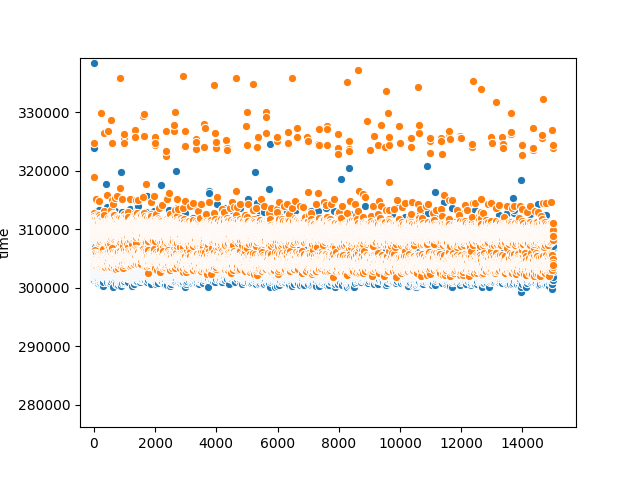

In [506]:
f = '~/nfs/maxdml/test_traces'
df = pd.read_csv(f, delimiter='\t')
df['time'] = df.COMPLETED - df.SENDING;
sns.scatterplot(x=df.index, y='time', data=df)

<IPython.core.display.Javascript object>


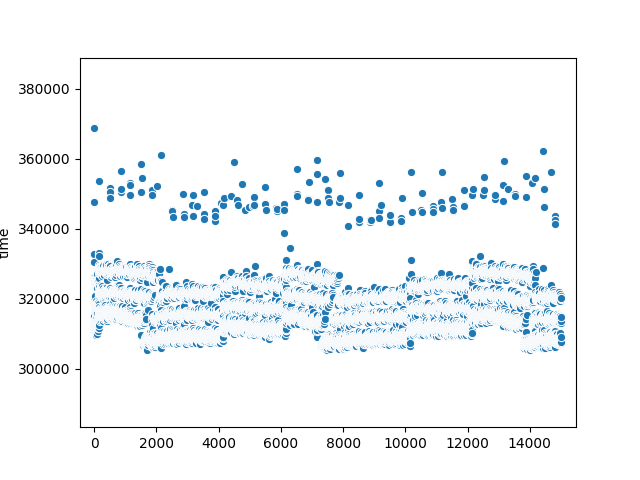

In [508]:
f = '~/nfs/maxdml/test_traces'
df = pd.read_csv(f, delimiter='\t')
df['time'] = df.COMPLETED - df.SENDING;
sns.scatterplot(x=df.index, y='time', data=df)